In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mplt
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [2]:
TRAIN_PATH = "../data/train.csv"
TEST_PATH = '../data/test.csv'
Full_train = pd.read_csv(TRAIN_PATH,index_col='Id')
Full_train = Full_train.rename(columns={'SalePrice' : 'price'})
Full_test = pd.read_csv(TEST_PATH)
Full_train.dropna(axis=0,subset=['price'], inplace=True)
y_full = Full_train.price
X_full = Full_train.drop(axis=1, columns=['price'])

In [3]:
Full_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,price
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


In [4]:
#columns_to_drop = ['MoSold','YrSold'] # these columns could be cause of data leakage, it is better to drop them
#X_full.drop(columns_to_drop, axis=1, inplace=True)

In [5]:
all_numeric_col = list((X_full.select_dtypes(exclude='object')).columns)
string_col = list((X_full.select_dtypes(include='object')).columns)
low_categorical_col = [col for col in X_full.columns
                  #if X_full[col].dtype == 'object' and X_full[col].nunique() <10]
                       if X_full[col].nunique() <25]

these numeric columnns probably are categorical variables, so these columns shoulb be count as categorical, not numerical

In [6]:
cat_from_num = list(X_full[low_categorical_col].select_dtypes(exclude='object').columns)


In [7]:
numeric_col = []
for col in all_numeric_col:
    if col in cat_from_num:
        continue
    numeric_col.append(col)

# Explore data
## column dtypes

In [8]:
# to see dtypes of all columns, we need change max_rows
pd.set_option('display.max_rows', 80)
Full_train.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object
HeatingQC         object


### find all nans
Probably, the only missed value is 'Electricial'(or maybe there was no electricity in this house?), in others cases nan is another category

In [9]:
Full_train.isna().sum()[Full_train.isna().sum() > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [10]:
Full_train[numeric_col].isna().sum()[Full_train[numeric_col].isna().sum() > 0]

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

LotFrontage is linear feet of street connected to property,
MasVnrArea is Masonry veneer area in square feet. So, it can be NaN


GarageYrBlt can be nan if no garage exist

In [11]:
missed_numeric_values = Full_train[numeric_col].isna().sum()[Full_train[numeric_col].isna().sum() > 0].index
print(missed_numeric_values)

Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object')


## numeric data
correlation between numeric cols

In [12]:
full_x_corr = Full_train[numeric_col].join(y_full).corr()

<AxesSubplot:>

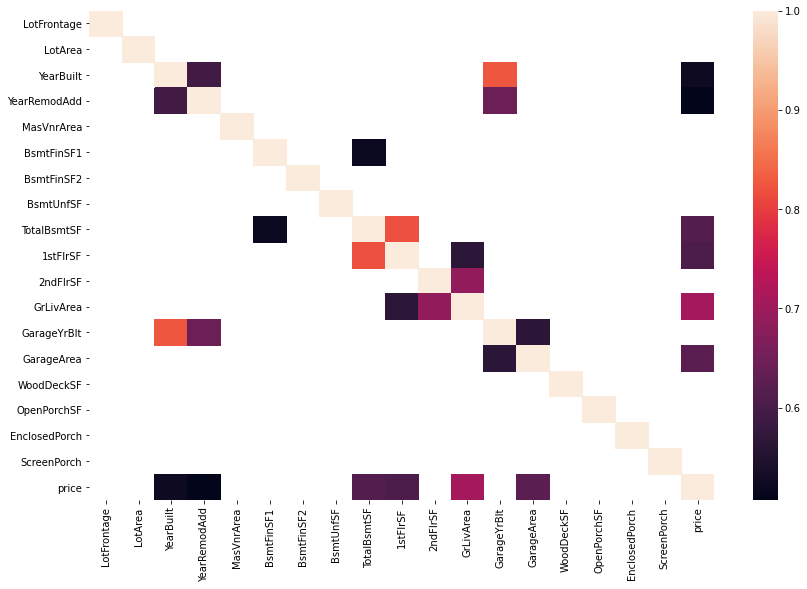

In [13]:
plt.figure(figsize=(14,9))
sns.heatmap(full_x_corr, mask=abs(full_x_corr) < 0.5, xticklabels=True, yticklabels=True)

These features has high correlation with price

In [14]:
price_corr = full_x_corr.loc['price']
price_corr = price_corr.iloc[:-1] # last row is correlation with itself, so it will be dropped

In [15]:
price_corr.loc[(abs(price_corr) >= 0.25) & (abs(price_corr) <= 0.5)]

LotFrontage    0.351799
LotArea        0.263843
MasVnrArea     0.477493
BsmtFinSF1     0.386420
2ndFlrSF       0.319334
GarageYrBlt    0.486362
WoodDeckSF     0.324413
OpenPorchSF    0.315856
Name: price, dtype: float64

In [16]:
strong_corr = price_corr.loc[abs(price_corr) >= 0.75]
strong_corr

Series([], Name: price, dtype: float64)

In [17]:
moderate_corr = price_corr.loc[(abs(price_corr) >= 0.5) & ~(price_corr.index.isin(strong_corr.index))]
moderate_corr

YearBuilt       0.522897
YearRemodAdd    0.507101
TotalBsmtSF     0.613581
1stFlrSF        0.605852
GrLivArea       0.708624
GarageArea      0.623431
Name: price, dtype: float64

These features have high correlation of features that influence the price

maybe they should be categorical

In [18]:
from_num_to_cat = ['GarageCars', 'GarageYrBlt', 'YearBuilt', 'BedroomAbvGr', '2ndFlrSF']

It was tested, without rows containing NaN, with 2 last features model performs slight better.(but a bit of worse comparing to using all rows without last 2 columns). It is possible that without dropping NaNs (imputing them) model could perforrm better ( need teest id)

# GarageCars

since GarageArea contains information on how many cars can fit in the garage, needed only one of them: either GarageCars or GarageArea

## GarageYrBlt
trying different things it was concluded, that there is no linear relationship between garageYrBuilt and price. But, perhaps, there *is* relationship, see the graphics below

### Bin GarageYrBlt

In [19]:
def find_best_bins_split(k, feature):
    best_corr = 0
    best_split = 0
    for k_bins in range(1,k):
        bins = np.linspace(Full_train[feature].min(), Full_train[feature].max(), k_bins)
        years = pd.cut(Full_train[feature], bins=bins, include_lowest=True) # splitting original column on k bins and creating categorical variable
        le = LabelEncoder()
        le.fit(years)
        encoded = pd.Series(le.transform(years)) # encoding categorical variable
        y = Full_train['price'].reset_index().price 
        corr = encoded.to_frame().join(y).corr()['price'].iloc[0]
        if abs(corr) > best_corr:
            best_corr = corr
            best_split = k_bins
    return best_split, best_corr

In [20]:
Full_train['GarageYrBlt'].nunique()

97

In [21]:
split, corr_coeff = find_best_bins_split(97,'GarageYrBlt')

In [22]:
corr_coeff

0.3847687969006023

In [23]:
split

95

The best possible split is using all (almost) columns, hence there is no use in equall split.

#### replacing Year of build on Age of garage

In [24]:
Full_train['GarageYrBlt']

Id
1       2003.0
2       1976.0
3       2001.0
4       1998.0
5       2000.0
         ...  
1456    1999.0
1457    1978.0
1458    1941.0
1459    1950.0
1460    1965.0
Name: GarageYrBlt, Length: 1460, dtype: float64

In [230]:
age_of_garage = Full_train['YrSold'] - Full_train['GarageYrBlt']
age_of_garage.name = 'GarageAge'

In [26]:
age_of_garage.isna().sum()

81

In [27]:
age_of_garage.nunique()

101

In [28]:
age_of_garage.replace(np.nan, 0).corr(y_full)

-0.3898082004901332

In [29]:
age_of_garage.corr(y_full)

-0.48706858845296663

In [30]:
data = age_of_garage.to_frame().join(y_full)
data.columns = ['age', 'price']

### Perhaps, there is non-linear relationship between garage and price

<AxesSubplot:xlabel='age'>

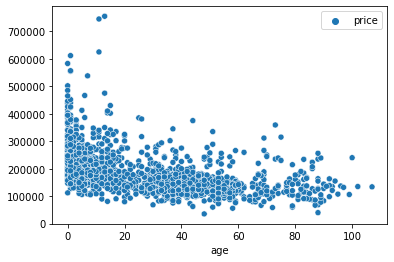

In [31]:
sns.scatterplot(data=data.set_index('age'))

<AxesSubplot:xlabel='GarageYrBlt', ylabel='price'>

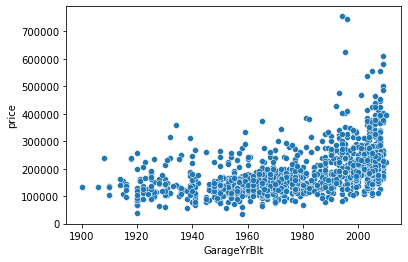

In [32]:
sns.scatterplot(x=Full_train['GarageYrBlt'], y=y_full)

## YearBuilt

In [33]:
feature = 'YearBuilt'
bins = np.linspace(Full_train[feature].min(), Full_train[feature].max(), 13)
years = pd.cut(Full_train[feature], bins=bins, include_lowest=True)

In [34]:
le = LabelEncoder()
le.fit(years)

LabelEncoder()

In [35]:
encoded = le.transform(years)

In [36]:
pd.Series(encoded).to_frame().join(y_full).corr()

,0,price
0,1.000000,-0.014599
price,-0.014599,1.000000


I do not know how exactly I should bin the YearBuilt for best result, but I can say this feature is worth further examination

In [37]:
Full_train['YearBuilt'].nunique()

112

In [38]:
find_best_bins_split(112,'YearBuilt')

(111, 0.5352166886201967)

### Age of house

In [229]:
age_house = Full_train['YrSold'] - Full_train['YearBuilt']
age_house.name = 'HouseAge'

In [40]:
age_house.corr(y_full)

-0.523350417546816

In [41]:
Full_train['YearBuilt'].corr(y_full)

0.5228973328794969

<AxesSubplot:ylabel='price'>

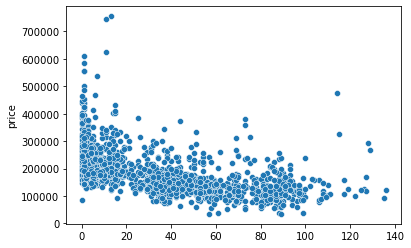

In [42]:
sns.scatterplot(x=age_house, y=y_full)

## BedroomAbvGr

In [43]:
feature  = 'BedroomAbvGr'
Full_train[feature]

Id
1       3
2       3
3       3
4       3
5       4
       ..
1456    3
1457    3
1458    4
1459    2
1460    3
Name: BedroomAbvGr, Length: 1460, dtype: int64

<AxesSubplot:xlabel='BedroomAbvGr', ylabel='price'>

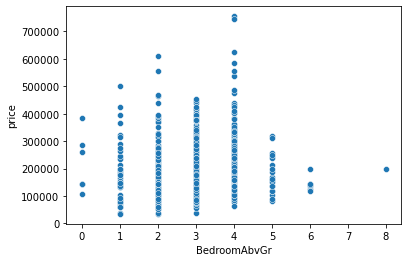

In [44]:
sns.scatterplot(x=Full_train[feature], y=y_full)

there is no any relationship in BedroomAbvGr

## 2ndFlrSF

In [45]:
feature = '2ndFlrSF'
Full_train[feature]

Id
1        854
2          0
3        866
4        756
5       1053
        ... 
1456     694
1457       0
1458    1152
1459       0
1460       0
Name: 2ndFlrSF, Length: 1460, dtype: int64

<AxesSubplot:xlabel='2ndFlrSF', ylabel='price'>

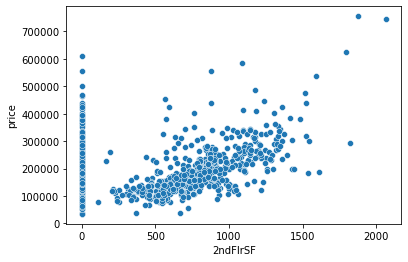

In [46]:
sns.scatterplot(x=Full_train[feature], y=y_full)

<AxesSubplot:xlabel='2ndFlrSF', ylabel='price'>

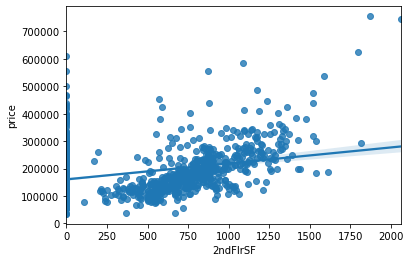

In [47]:
sns.regplot(x=Full_train[feature], y=y_full)

<AxesSubplot:xlabel='2ndFlrSF', ylabel='price'>

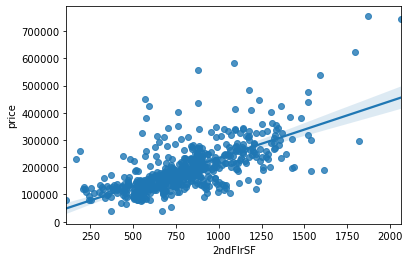

In [48]:
flr2_no0 = Full_train[feature].loc[Full_train[feature] != 0]
sns.regplot(x=flr2_no0, y=y_full.loc[flr2_no0.index])

In [49]:
flr2_no0.corr(y_full.loc[flr2_no0.index])

0.6733048324568377

If there is no 2 floor, then price depend on other features. But if the second floor exists, then there is some kind of linear relationship

This feature worth further examination

# Handling missed value
But do I really need to handle it? Will correlation be increased if these features didnot have NaN, or, rather, was categorical

In [50]:
missed_num_df = Full_train[missed_numeric_values].copy()

In [51]:
missed_num_df.isna().sum()

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

GarageYrBlt - I will not use this feature, no need to do something with this column

In [52]:
missed_num_df.drop(columns='GarageYrBlt', inplace=True)

In [53]:
missed_num_df.corrwith(Full_train['price'])

LotFrontage    0.351799
MasVnrArea     0.477493
dtype: float64

In [54]:
missed_num_df

,LotFrontage,MasVnrArea
Id,,
1,65.0,196.0
2,80.0,0.0
3,68.0,162.0
4,60.0,0.0
5,84.0,350.0
...,...,...
1456,62.0,0.0
1457,85.0,119.0
1458,66.0,0.0


In [55]:
missed_num_df['MasVnrArea'].value_counts()

0.0      861
108.0      8
72.0       8
180.0      8
16.0       7
        ... 
31.0       1
366.0      1
528.0      1
894.0      1
415.0      1
Name: MasVnrArea, Length: 327, dtype: int64

In [56]:
861/1460

0.5897260273972603

There is about 861 zeros, more that 50% of dataset contains non-meaningful information, and there is no even moderate correlation, I doubt I can do something to increase correlation, so I drop it either

In [57]:
missed_num_df.drop(columns='MasVnrArea', inplace=True)

LotFrontage - I doubt I even need this feature ( Linear feet of street connected to property), so I dropping this as well

as result - I do not use columns with missed values, so I do not need to somehow handle it

In [188]:
num_cols_to_drop = ['MasVnrArea', 'LotFrontage', 'GarageYrBlt']

### Finding best features
checking correlation and p-value for numeric features

In [191]:
F_P = {}
for feature in numeric_col:
    # skip features that will be dropped anyway
    if feature in num_cols_to_drop:
        continue
    pearson_coef, p_value = stats.pearsonr(Full_train[feature],y_full)
    F_P[feature] = (pearson_coef, p_value)
    #print('Feature:',feature)
    #print('The correlation coefficient is:', pearson_coef, 'the p-value is:', p_value)
for k in F_P:
    print(k, F_P[k])

LotArea (0.2638433538714057, 1.1231391549193063e-24)
YearBuilt (0.5228973328794968, 2.9902290990158995e-103)
YearRemodAdd (0.5071009671113862, 3.1649482419200737e-96)
BsmtFinSF1 (0.3864198062421533, 3.3941098292907553e-53)
BsmtFinSF2 (-0.011378121450215144, 0.663998650834577)
BsmtUnfSF (0.2144791055469689, 1.1829757963600795e-16)
TotalBsmtSF (0.6135805515591954, 9.484229391507914e-152)
1stFlrSF (0.6058521846919146, 5.394710618971284e-147)
2ndFlrSF (0.31933380283206786, 5.764335119183061e-36)
GrLivArea (0.708624477612652, 4.518033646780971e-223)
GarageArea (0.6234314389183616, 5.2650381679802e-158)
WoodDeckSF (0.3244134445681299, 3.972216535629994e-37)
OpenPorchSF (0.3158562271160553, 3.493373623097777e-35)
EnclosedPorch (-0.12857795792595675, 8.255770475119532e-07)
ScreenPorch (0.1114465711429112, 1.9721400194702135e-05)


In [192]:
for k in F_P:
    if F_P[k][0] > 0.5:
        print(k, F_P[k])

YearBuilt (0.5228973328794968, 2.9902290990158995e-103)
YearRemodAdd (0.5071009671113862, 3.1649482419200737e-96)
TotalBsmtSF (0.6135805515591954, 9.484229391507914e-152)
1stFlrSF (0.6058521846919146, 5.394710618971284e-147)
GrLivArea (0.708624477612652, 4.518033646780971e-223)
GarageArea (0.6234314389183616, 5.2650381679802e-158)


In [193]:
for k in F_P:
    if F_P[k][1] < 0.05:
        print(k, F_P[k])

LotArea (0.2638433538714057, 1.1231391549193063e-24)
YearBuilt (0.5228973328794968, 2.9902290990158995e-103)
YearRemodAdd (0.5071009671113862, 3.1649482419200737e-96)
BsmtFinSF1 (0.3864198062421533, 3.3941098292907553e-53)
BsmtUnfSF (0.2144791055469689, 1.1829757963600795e-16)
TotalBsmtSF (0.6135805515591954, 9.484229391507914e-152)
1stFlrSF (0.6058521846919146, 5.394710618971284e-147)
2ndFlrSF (0.31933380283206786, 5.764335119183061e-36)
GrLivArea (0.708624477612652, 4.518033646780971e-223)
GarageArea (0.6234314389183616, 5.2650381679802e-158)
WoodDeckSF (0.3244134445681299, 3.972216535629994e-37)
OpenPorchSF (0.3158562271160553, 3.493373623097777e-35)
EnclosedPorch (-0.12857795792595675, 8.255770475119532e-07)
ScreenPorch (0.1114465711429112, 1.9721400194702135e-05)


We can see, that the only meaningfull values are same that in good_correlation. But there is some features that wee can add to see how it will influence on SalesPrice.(Having fireplace, Pool, 2nd floor etc.)

#### Creating new features
We can try to create new features and see, how it will work out

In [194]:
porch = ['EnclosedPorch', 'OpenPorchSF','3SsnPorch','ScreenPorch']
BSM_bath = ['BsmtFullBath', 'BsmtHalfBath']
bath = ['FullBath', 'HalfBath']

In [195]:
for col in Full_train.columns:
    if 'area' in str.lower(col):
        print(col)

LotArea
MasVnrArea
GrLivArea
GarageArea
PoolArea


In [63]:
areas = ['LotArea', 'MasVnrArea', 'GrLivArea','GarageArea','PoolArea']

In [198]:
new_features_df = pd.DataFrame(index=Full_train.index)
new_features_df['Has_pool'] = Full_train['PoolArea'] > 0
new_features_df['Has_fireplace'] = Full_train['Fireplaces'] > 0
new_features_df['Total_porch'] = Full_train[porch].sum(axis=1)
new_features_df['Total_BSM_bath'] = Full_train[BSM_bath].sum(axis=1)
new_features_df['Has_2flr'] = Full_train['2ndFlrSF'] > 0
new_features_df['Total_Bath'] = Full_train[bath].sum(axis=1)
new_features_df['Has_garage'] = Full_train['GarageArea'] > 0
new_features_df['Total_area'] = Full_train[areas].sum(axis=1)
new_features_df

,Has_pool,Has_fireplace,Total_porch,Total_BSM_bath,Has_2flr,Total_Bath,Has_garage,Total_area
Id,,,,,,,,
1,False,False,61,1,True,3,True,10904.0
2,False,True,0,1,False,2,True,11322.0
3,False,True,42,1,True,3,True,13806.0
4,False,True,307,1,True,1,True,11909.0
5,False,True,84,1,True,3,True,17644.0
...,...,...,...,...,...,...,...,...
1456,False,True,40,0,True,3,True,10024.0
1457,False,True,0,1,False,2,True,15867.0
1458,False,True,60,0,True,2,True,11634.0


In [199]:
bools = ['Has_pool', 'Has_fireplace', 'Has_2flr', 'Has_garage']

In [200]:
new_features_df[bools] = new_features_df[bools].astype(int)
new_features_df.dtypes

Has_pool            int64
Has_fireplace       int64
Total_porch         int64
Total_BSM_bath      int64
Has_2flr            int64
Total_Bath          int64
Has_garage          int64
Total_area        float64
dtype: object

In [202]:
new_added_cols = list(new_features_df.columns)

Now lets repeat process with correaltion and p_value

In [204]:
for feature in new_added_cols:
    pearson_coef, p_value = stats.pearsonr(new_features_df[feature],y_full)
    print('Feature:',feature)
    print('The correlation coefficient is:', pearson_coef, 'the p-value is:', p_value)

Feature: Has_pool
The correlation coefficient is: 0.09370812512551797 the p-value is: 0.0003365523814304674
Feature: Has_fireplace
The correlation coefficient is: 0.47190806851649414 the p-value is: 7.680089360240953e-82
Feature: Total_porch
The correlation coefficient is: 0.1957389407838354 the p-value is: 4.492606999065129e-14
Feature: Total_BSM_bath
The correlation coefficient is: 0.211519992245997 the p-value is: 3.139841430959628e-16
Feature: Has_2flr
The correlation coefficient is: 0.13765568369462586 the p-value is: 1.2885477358281001e-07
Feature: Total_Bath
The correlation coefficient is: 0.5682665118032032 the p-value is: 1.2536311830234688e-125
Feature: Has_garage
The correlation coefficient is: 0.23683171182004337 the p-value is: 4.627259402066537e-20
Feature: Total_area
The correlation coefficient is: 0.31631107513285217 the p-value is: 2.763682941910124e-35


Total_Bath is new feature that worth attention
(probably it is not linear), but Has_fireplace and Total_area also good enough

In [207]:
selected_new_features_df = new_features_df[['Total_area', 'Has_fireplace', 'Total_Bath']].join(y_full)

<AxesSubplot:xlabel='Total_Bath', ylabel='price'>

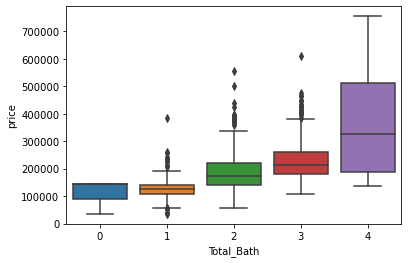

In [208]:
sns.boxplot(x='Total_Bath', y='price', data=selected_new_features_df)

<AxesSubplot:xlabel='Has_fireplace', ylabel='price'>

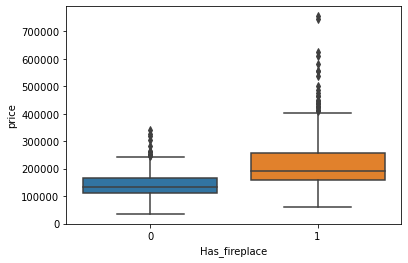

In [209]:
sns.boxplot(x='Has_fireplace', y='price', data=selected_new_features_df)

<AxesSubplot:xlabel='Total_area', ylabel='price'>

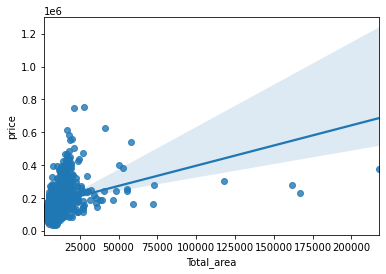

In [211]:
sns.regplot(x='Total_area', y='price', data=selected_new_features_df)

In [220]:
idx = selected_new_features_df[selected_new_features_df['Total_area'] > 50000].index

<AxesSubplot:xlabel='Total_area', ylabel='price'>

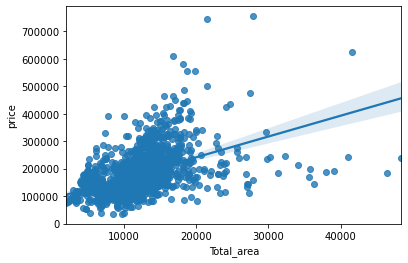

In [221]:
sns.regplot(x='Total_area', y='price', data=selected_new_features_df.drop(index=idx))

In [225]:
goodCorr = list(price_corr.loc[(abs(price_corr) >= 0.25)].index)

# Creating new DataFrame
## This features will be used for training

In [236]:
GlobalNewDF = Full_train[goodCorr].join(age_of_garage).join(age_house).drop(columns=num_cols_to_drop).join(selected_new_features_df)

In [241]:
GlobalNewDF.columns

Index(['LotArea', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'GarageAge', 'HouseAge', 'Total_area', 'Has_fireplace',
       'Total_Bath', 'price'],
      dtype='object')

In [72]:
features_num_good_corr = list(price_corr.sort_values(ascending=False).index)
features_num_good_corr += ['Total_Bath']
features_num_good_corr = features_num_good_corr[1:] # remove SalePrice
print(features_num_good_corr[1:])

['TotalBsmtSF', '1stFlrSF', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'LotArea', 'BsmtUnfSF', 'ScreenPorch', 'BsmtFinSF2', 'EnclosedPorch', 'Total_Bath']


In [73]:
price_corr.sort_values(ascending=False)

GrLivArea        0.708624
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
LotArea          0.263843
BsmtUnfSF        0.214479
ScreenPorch      0.111447
BsmtFinSF2      -0.011378
EnclosedPorch   -0.128578
Name: price, dtype: float64

# Categorical variables

## low_cardinality features

In [237]:
low_cardinality_df = Full_train[low_categorical_col]
low_cardinality_df

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,...,3SsnPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Feedr,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Norm,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Norm,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,Norm,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1457,20,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,...,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1458,70,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,...,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal


In [238]:
low_cardinality_df.isna().sum()[low_cardinality_df.isna().sum() > 0]

Alley           1369
MasVnrType         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

I will return to handling nans later, for now I will drop it

In [76]:
low_cardinality_cols_with_nans = list(low_cardinality_df.isna().sum()[low_cardinality_df.isna().sum() > 0].index)

In [77]:
without_nan_df = low_cardinality_df.dropna(axis=1)
without_nan_df

,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,...,Fireplaces,GarageCars,PavedDrive,3SsnPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,0,2,Y,0,0,0,2,2008,WD,Normal
2,20,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Feedr,Norm,...,1,2,Y,0,0,0,5,2007,WD,Normal
3,60,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,1,2,Y,0,0,0,9,2008,WD,Normal
4,70,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,...,1,3,Y,0,0,0,2,2006,WD,Abnorml
5,60,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,Norm,Norm,...,1,3,Y,0,0,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,1,2,Y,0,0,0,8,2007,WD,Normal
1457,20,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,2,2,Y,0,0,0,2,2010,WD,Normal
1458,70,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,2,1,Y,0,0,2500,5,2010,WD,Normal


In [78]:
without_nan_df.describe(include=['object'])

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,BldgType,...,ExterCond,Foundation,Heating,HeatingQC,CentralAir,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,...,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
unique,5,2,4,4,2,5,3,9,8,5,...,5,6,6,5,2,4,7,3,9,6
top,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,...,TA,PConc,GasA,Ex,Y,TA,Typ,Y,WD,Normal
freq,1151,1454,925,1311,1459,1052,1382,1260,1445,1220,...,1282,647,1428,741,1365,735,1360,1340,1267,1198


In [79]:
without_nan_df = without_nan_df.join(y_full)

### Find significant categorical features
but first declare some valuable functions

# Do I need it?

In [80]:
def get_dic_name_need_change():
    dic = {}
    y = find_n_percent_of_data(Full_train.shape[0], 5)
    for col_info in cols_with_big_F_score+cols_with_low_F_score:
        col_name = col_info[0]
        values_less_then_y = Full_train[col_name].value_counts() < y    
        values = []
        for i in range(1,len(values_less_then_y)):
            group_value_counts = values_less_then_y.iloc[-i]
            if group_value_counts:
                group_value = values_less_then_y.index[-i]
                values.append(group_value)

        if len(values) > 0:
            dic[values_less_then_y.name] = values
    return dic

Func, that score ANOVA for specific dataframe

In [81]:
def score_ANOVA(data, col_name='price'):
    '''
    score ANOVA for all columns in data with col_name. Last column must be col_name - this is the exit point.
    return 3 lists:
    cols_that_need_further_investigation - ANOVA <=10;
    cols_with_big_F_score - ANOVA > 50
    cols_with_low_F_score - ANOVA <= 50
    '''
    cols_that_need_further_investigation = []
    cols_with_big_F_score = []
    cols_with_low_F_score = []
    
    for col in data.columns:
        if col == col_name:
            break
        df = data[[col,col_name]]
        grouped_col_price = df.groupby([col],as_index=False)
        uniques_col_values = df[col].unique()
        if len(uniques_col_values) == 1:
            print(f'cols has only one value! ({col})')
            continue
        args = [grouped_col_price.get_group(uniques_col_values[i])[col_name] for i in range(len(uniques_col_values))]
        f_val, p_val = stats.f_oneway(*args)
        #print('column name: ',col)
        #print( "ANOVA results: F=", f_val, ", P =", p_val)  
        if (f_val <=10):
            cols_that_need_further_investigation.append([col, f_val, p_val])
        elif (f_val > 50):
            cols_with_big_F_score.append([col, f_val, p_val])
        else:
            cols_with_low_F_score.append([col, f_val, p_val])
    cols_that_need_further_investigation.sort(key=lambda x:x[1], reverse=True)
    cols_with_big_F_score.sort(key=lambda x:x[1], reverse=True)
    cols_with_low_F_score.sort(key=lambda x:x[1], reverse=True)
    return cols_that_need_further_investigation, cols_with_big_F_score, cols_with_low_F_score

Func that creating boxplot on giving data and columns

In [82]:
# column_info is list contains [col_name, f_val, p_val]
def make_boxplots(column_info, data, subplot_size=[4,4,1]):
    r = subplot_size[0]
    c = subplot_size[1]
    i = subplot_size[2]
    plt.figure(figsize=(20,20))
    for col in column_info:
        #plt.figure()
        plt.subplot(r,c,i)
        i+=1
        sns.boxplot(data=data, y=y_full, x=col[0])

In [83]:
def find_n_percent_of_data(total_rows, n=5):
    '''
    total_rows => 100%
     y => n%
     we know n(5%, for example), so we find y on this formula:
     y = n*total_rows/100
    ''' 
    return n * total_rows / 100

Dist plot will be plotted with red line, where red line shows 5% of data

In [84]:
def make_dist(data, col_info_list):
    y = find_n_percent_of_data(data.shape[0],5)
    i = 1
    plt.figure(figsize=(20,20))
    for col_info in col_info_list:
        col_name = col_info[0]
        #plt.figure()
        plt.subplot(4,5,i)
        i += 1
        sns.histplot(data[col_name])
        plt.xticks(rotation=45)
        plt.axhline(y,color='r')

### applying ANOVA method

In [85]:
cols_that_need_further_investigation, cols_with_big_F_score, cols_with_low_F_score = score_ANOVA(without_nan_df)

In [86]:
cols_that_need_further_investigation

[['KitchenAbvGr', 9.835524893747184, 2.011735142857873e-06],
 ['ExterCond', 8.798714214177485, 5.106680608671862e-07],
 ['PoolArea', 7.8473183422853365, 2.341047098544491e-09],
 ['LotConfig', 7.809954123467792, 3.163167473604189e-06],
 ['RoofMatl', 6.727304893420313, 7.231444779987188e-08],
 ['Condition1', 6.118017137125925, 8.904549416138853e-08],
 ['Heating', 4.259818559406287, 0.000753472106445497],
 ['Functional', 4.0578754277920215, 0.0004841696801078294],
 ['Street', 2.4592895583691994, 0.11704860406782483],
 ['Condition2', 2.0738986215227877, 0.043425658360948464],
 ['LandSlope', 1.9588170374149438, 0.1413963584114019],
 ['LowQualFinSF', 1.176684079623019, 0.25565603616955446],
 ['3SsnPorch', 1.0400108577692064, 0.4102855100523331],
 ['MiscVal', 0.9881186602702413, 0.4736397759420298],
 ['MoSold', 0.9578652656318107, 0.48335232989243127],
 ['YrSold', 0.6455252211679311, 0.6300887663573457],
 ['Utilities', 0.29880407484898486, 0.5847167739689381],
 ['BsmtHalfBath', 0.221460798411

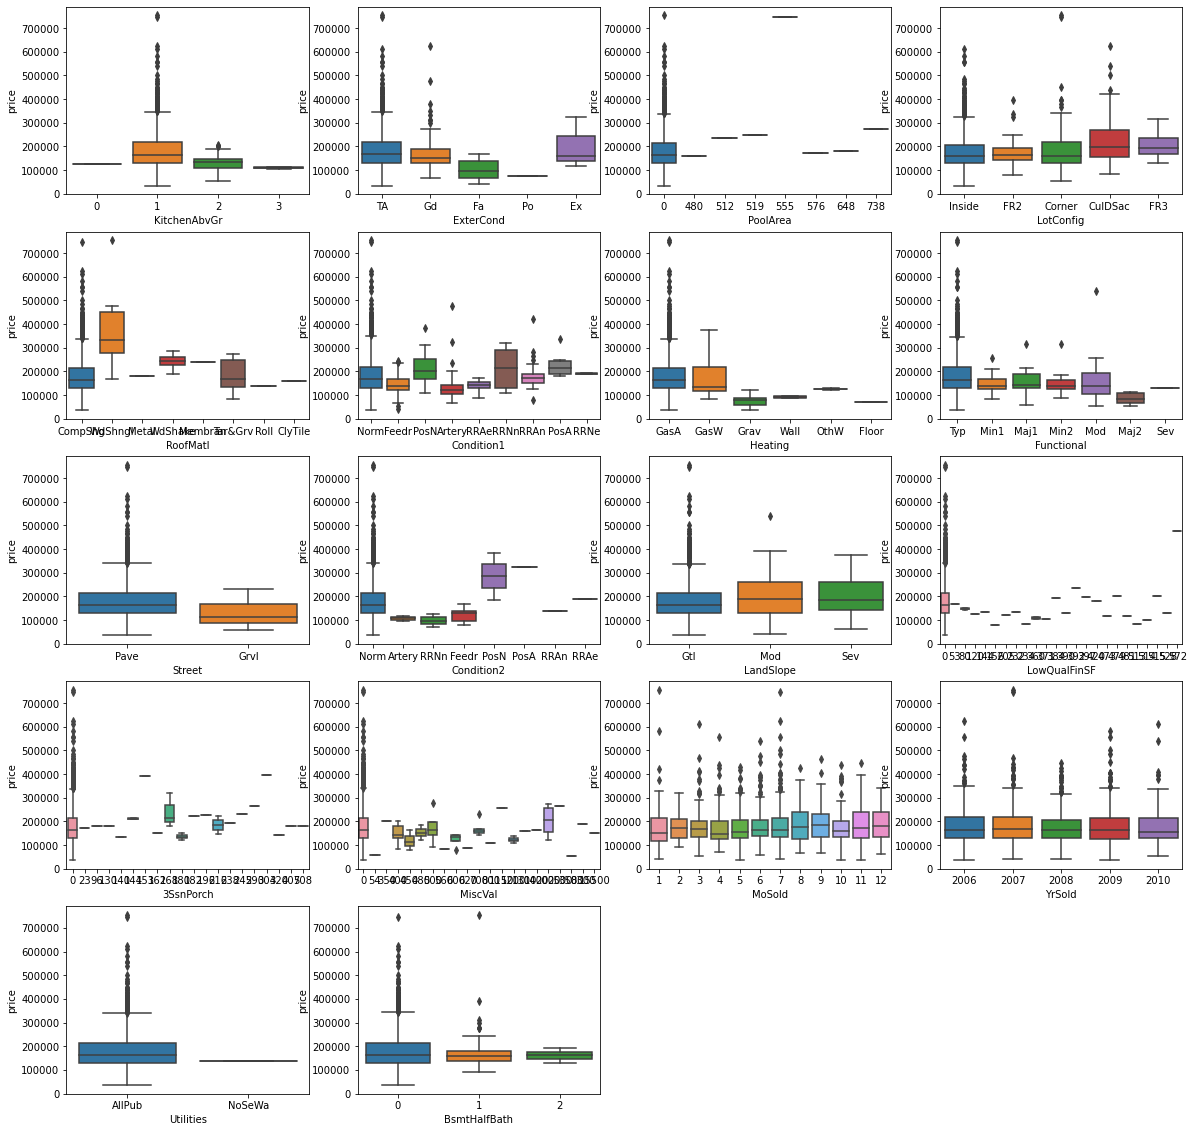

In [87]:
make_boxplots(cols_that_need_further_investigation,data=without_nan_df, subplot_size=[5,4,1])

It is clearly seen that these columns will be bad at predicting house price

In [88]:
all_rows = Full_train.shape[0] 
for col_info in cols_that_need_further_investigation:
    # get value_counts in percentage
    col_name = col_info[0]
    print(Full_train[col_name].value_counts() / all_rows * 100)

1    95.342466
2     4.452055
3     0.136986
0     0.068493
Name: KitchenAbvGr, dtype: float64
TA    87.808219
Gd    10.000000
Fa     1.917808
Ex     0.205479
Po     0.068493
Name: ExterCond, dtype: float64
0      99.520548
480     0.068493
512     0.068493
519     0.068493
555     0.068493
576     0.068493
648     0.068493
738     0.068493
Name: PoolArea, dtype: float64
Inside     72.054795
Corner     18.013699
CulDSac     6.438356
FR2         3.219178
FR3         0.273973
Name: LotConfig, dtype: float64
CompShg    98.219178
Tar&Grv     0.753425
WdShngl     0.410959
WdShake     0.342466
Membran     0.068493
ClyTile     0.068493
Roll        0.068493
Metal       0.068493
Name: RoofMatl, dtype: float64
Norm      86.301370
Feedr      5.547945
Artery     3.287671
RRAn       1.780822
PosN       1.301370
RRAe       0.753425
PosA       0.547945
RRNn       0.342466
RRNe       0.136986
Name: Condition1, dtype: float64
GasA     97.808219
GasW      1.232877
Grav      0.479452
Wall      0.273973
O

As we can see, very big percentage of data has one value, therefore these variables are no use

 #### Double check ExterCond and LotConfig
These groups doe not have enough samples for  different groups, so they are no use, but it is better to double check ExterCond and LotConfig, just to be sure

##### ExterCond

In [89]:
invest_df = Full_train[['ExterCond', 'LotConfig', 'price']]
group = invest_df.groupby(['ExterCond', 'LotConfig'],as_index=False).mean()
pivot = group.pivot(columns='ExterCond', index='LotConfig')
pivot
#f_score, p_val = stats.f_oneway()

price                                                      
ExterCond             Ex             Fa             Gd       Po             TA
LotConfig                                                                     
Corner               NaN  131500.000000  174562.857143      NaN  184091.265766
CulDSac              NaN            NaN  217655.833333      NaN  224761.756098
FR2                  NaN   81000.000000  148466.666667      NaN  182244.767442
FR3                  NaN            NaN            NaN      NaN  208475.000000
Inside     201333.333333   95364.952381  161375.781250  76500.0  180412.016112

<AxesSubplot:xlabel='None-ExterCond', ylabel='LotConfig'>

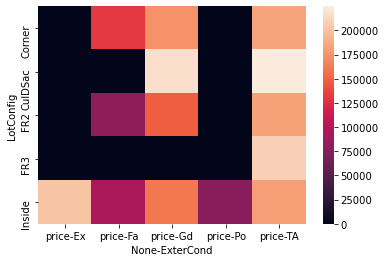

In [90]:
sns.heatmap(pivot.fillna(0))

Fa, Gd, Ta - There is no big difference between Fa and Gd. However, Ta is valued more. I believe there is no significant statisctical difference, So I will not use this column

In [91]:
invest_df['ExterCond'].value_counts()

TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64

It is clear, that Po and Ex are outliers

In [92]:
group = invest_df.groupby(['ExterCond'],as_index=False)
group.mean()

,ExterCond,price
0,Ex,201333.333333
1,Fa,102595.142857
2,Gd,168897.568493
3,Po,76500.000000
4,TA,184034.896256


In [93]:
stats.f_oneway(group.get_group('Ex')['price'], group.get_group('Fa')['price'], group.get_group('Gd')['price'])

F_onewayResult(statistic=11.376862271536252, pvalue=2.2724109908140543e-05)

Comparing previous result (ANOVA results: F= 8.798714214177485 , P = 5.106680608671862e-07), this is barely better. I decide to not use this columns as predicator

#### LotConfig

In [94]:
invest_df['LotConfig'].value_counts()

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

In [95]:
group = invest_df.groupby(['LotConfig'],as_index=False)
group.mean()

,LotConfig,price
0,Corner,181623.425856
1,CulDSac,223854.617021
2,FR2,177934.574468
3,FR3,208475.000000
4,Inside,176938.047529


In [96]:
stats.f_oneway(group.get_group('Corner')['price'], group.get_group('Inside')['price'], group.get_group('CulDSac')['price'])

F_onewayResult(statistic=15.160291081623821, pvalue=3.061664390718219e-07)

Comparing to the previous result (ANOVA results: F= 7.809954123467792 , P = 3.163167473604189e-06), thia ia barely better. However, it is not good enougfh, So, there is no need in picking this column

### Checking cols with good enough F_value

In [97]:
cols_with_big_F_score

[['ExterQual', 443.33483141504627, 1.4395510967787893e-204],
 ['KitchenQual', 407.80635155838866, 3.0322127528400614e-192],
 ['GarageCars', 351.2074862087728, 1.1211287650612485e-211],
 ['OverallQual', 349.02683956930736, 0.0],
 ['FullBath', 246.06700392492812, 3.8021879324489406e-129],
 ['Fireplaces', 146.74117584536646, 4.4210010307257784e-83],
 ['Foundation', 100.25385058740888, 5.791895002232233e-91],
 ['CentralAir', 98.30534356615253, 1.8095061559267854e-22],
 ['HeatingQC', 88.39446198869796, 2.667062092104357e-67],
 ['HalfBath', 74.46970052103694, 1.6091449454034875e-31],
 ['TotRmsAbvGrd', 56.16423822142646, 1.1917103366526644e-103]]

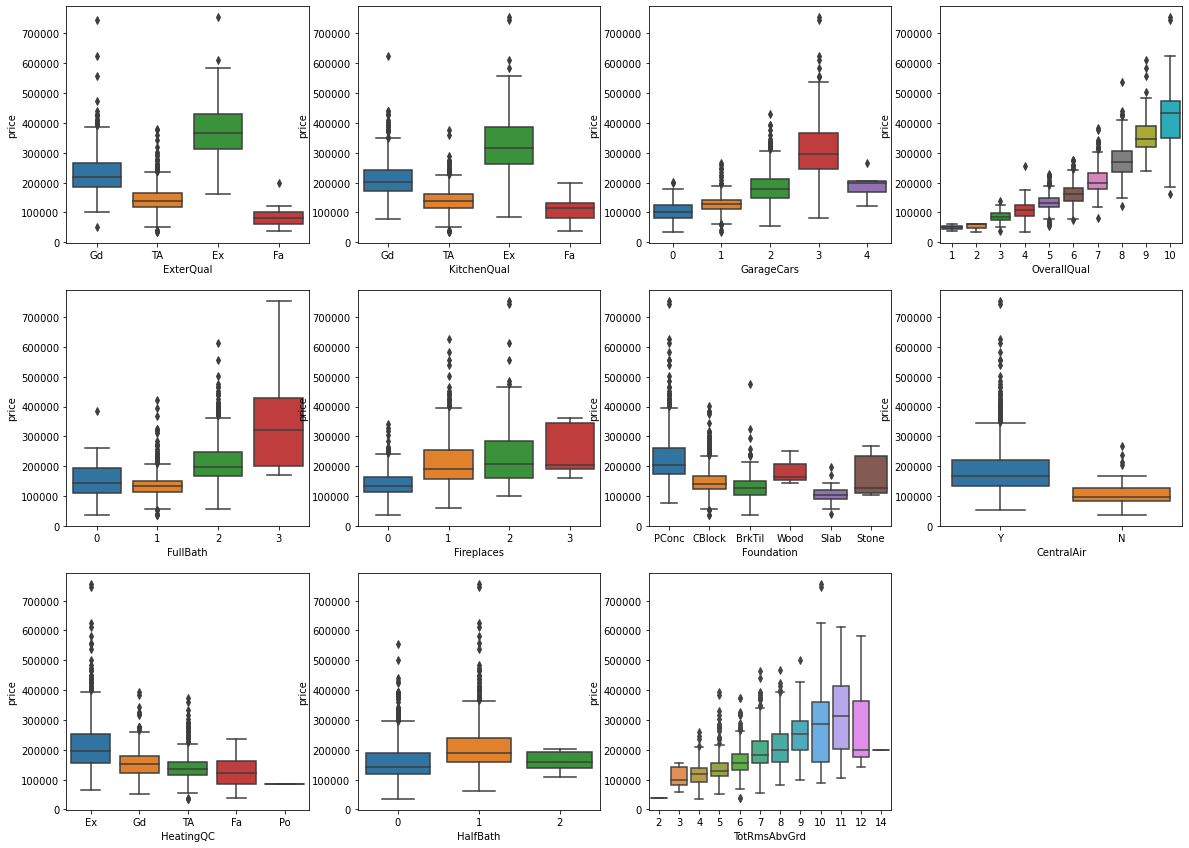

In [98]:
make_boxplots(cols_with_big_F_score, without_nan_df)

In [99]:
without_nan_df['HeatingQC'].value_counts()

Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: HeatingQC, dtype: int64

These columns are probably very good predicators, but need to pay attention HeatingQC: It is only one example of Po! It is not enough

In [100]:
cols_with_big_F_score

[['ExterQual', 443.33483141504627, 1.4395510967787893e-204],
 ['KitchenQual', 407.80635155838866, 3.0322127528400614e-192],
 ['GarageCars', 351.2074862087728, 1.1211287650612485e-211],
 ['OverallQual', 349.02683956930736, 0.0],
 ['FullBath', 246.06700392492812, 3.8021879324489406e-129],
 ['Fireplaces', 146.74117584536646, 4.4210010307257784e-83],
 ['Foundation', 100.25385058740888, 5.791895002232233e-91],
 ['CentralAir', 98.30534356615253, 1.8095061559267854e-22],
 ['HeatingQC', 88.39446198869796, 2.667062092104357e-67],
 ['HalfBath', 74.46970052103694, 1.6091449454034875e-31],
 ['TotRmsAbvGrd', 56.16423822142646, 1.1917103366526644e-103]]

In [101]:
cols_with_big_F_score

[['ExterQual', 443.33483141504627, 1.4395510967787893e-204],
 ['KitchenQual', 407.80635155838866, 3.0322127528400614e-192],
 ['GarageCars', 351.2074862087728, 1.1211287650612485e-211],
 ['OverallQual', 349.02683956930736, 0.0],
 ['FullBath', 246.06700392492812, 3.8021879324489406e-129],
 ['Fireplaces', 146.74117584536646, 4.4210010307257784e-83],
 ['Foundation', 100.25385058740888, 5.791895002232233e-91],
 ['CentralAir', 98.30534356615253, 1.8095061559267854e-22],
 ['HeatingQC', 88.39446198869796, 2.667062092104357e-67],
 ['HalfBath', 74.46970052103694, 1.6091449454034875e-31],
 ['TotRmsAbvGrd', 56.16423822142646, 1.1917103366526644e-103]]

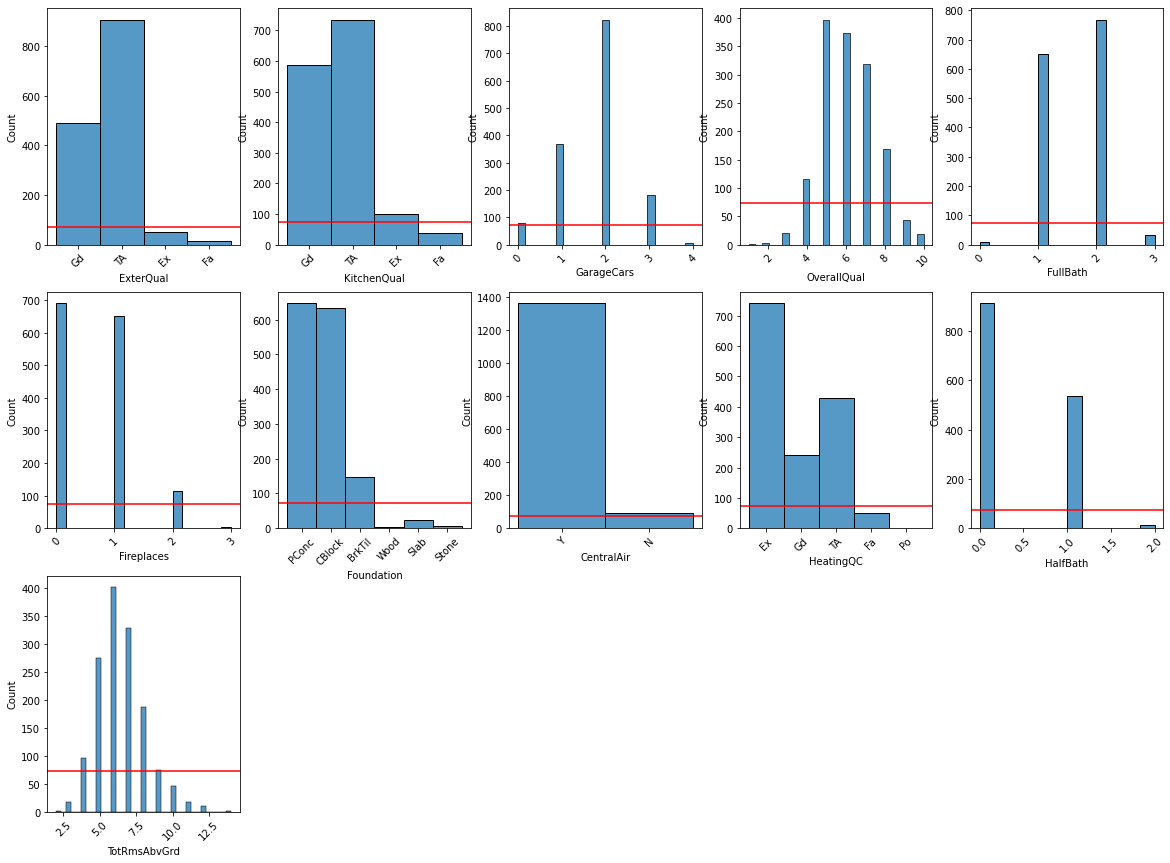

In [102]:
make_dist(without_nan_df,cols_with_big_F_score)

In [103]:
cols_with_low_F_score

[['SaleCondition', 45.57842830969571, 7.988268404991176e-44],
 ['MSZoning', 43.84028167245718, 8.817633866272648e-35],
 ['PavedDrive', 42.02417941762533, 1.803568890651533e-18],
 ['LotShape', 40.13285166226295, 6.447523852011766e-25],
 ['MSSubClass', 33.73207641062383, 8.66216626609302e-79],
 ['SaleType', 28.863054116984088, 5.039766889462451e-42],
 ['BsmtFullBath', 27.448014806098907, 2.88243552729416e-17],
 ['OverallCond', 26.00317308892095, 7.962288819950615e-38],
 ['HouseStyle', 19.595000995981223, 3.376776535121222e-25],
 ['Exterior1st', 18.61174286624578, 2.5860887286376316e-43],
 ['RoofStyle', 17.80549722914421, 3.653523047099125e-17],
 ['Exterior2nd', 17.500839571369834, 4.8421856706985465e-43],
 ['BldgType', 13.011077169620851, 2.0567364604967015e-10],
 ['BedroomAbvGr', 12.92541345911101, 3.3043196450461637e-16],
 ['LandContour', 12.850188333283924, 2.7422167521379096e-08]]

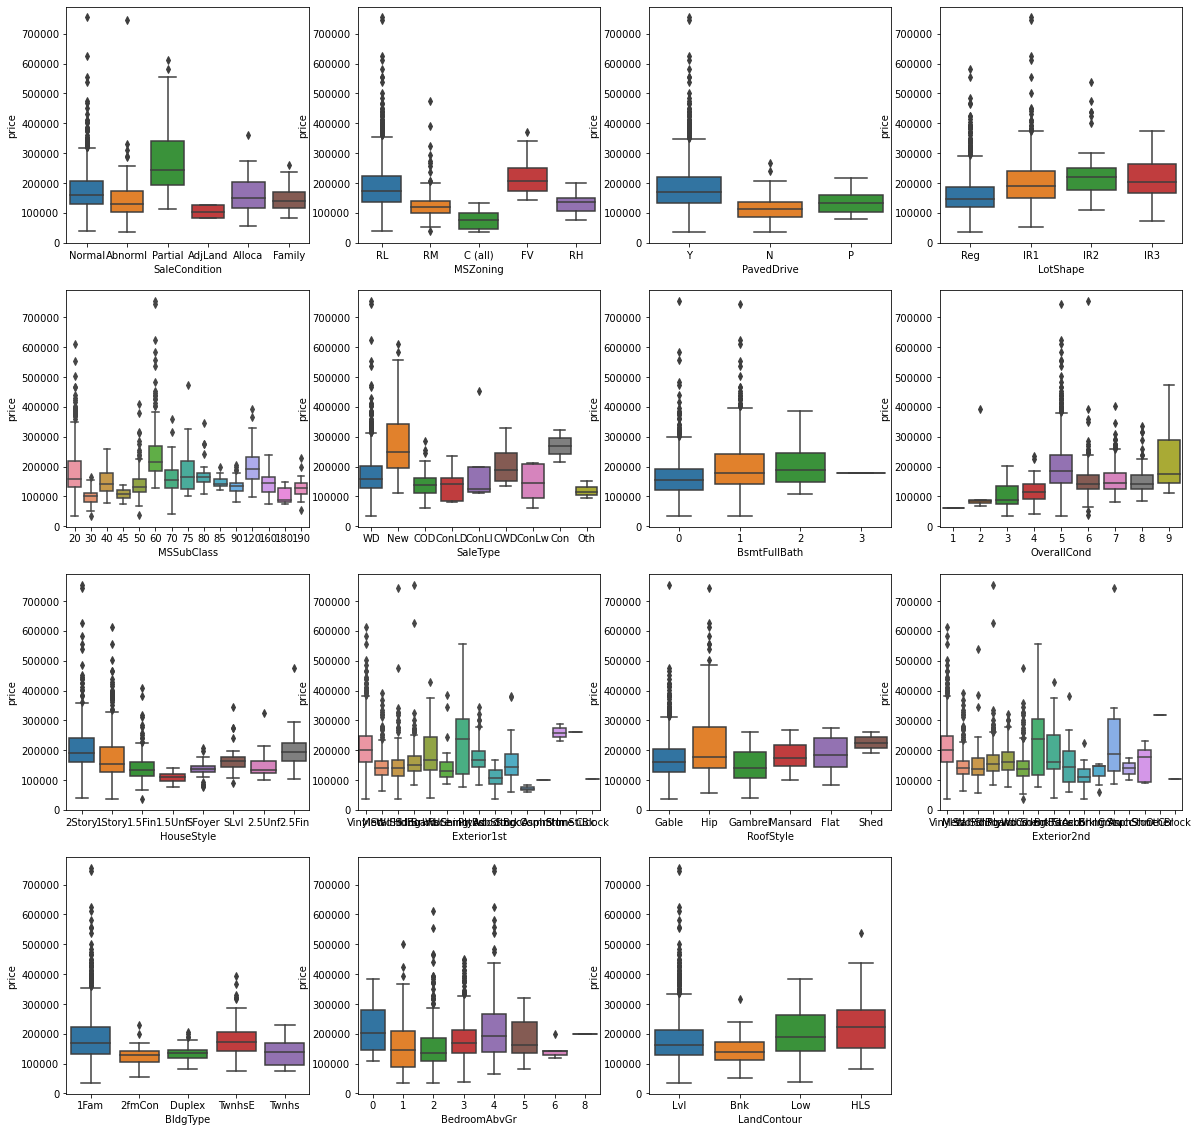

In [104]:
make_boxplots(cols_with_low_F_score, without_nan_df)

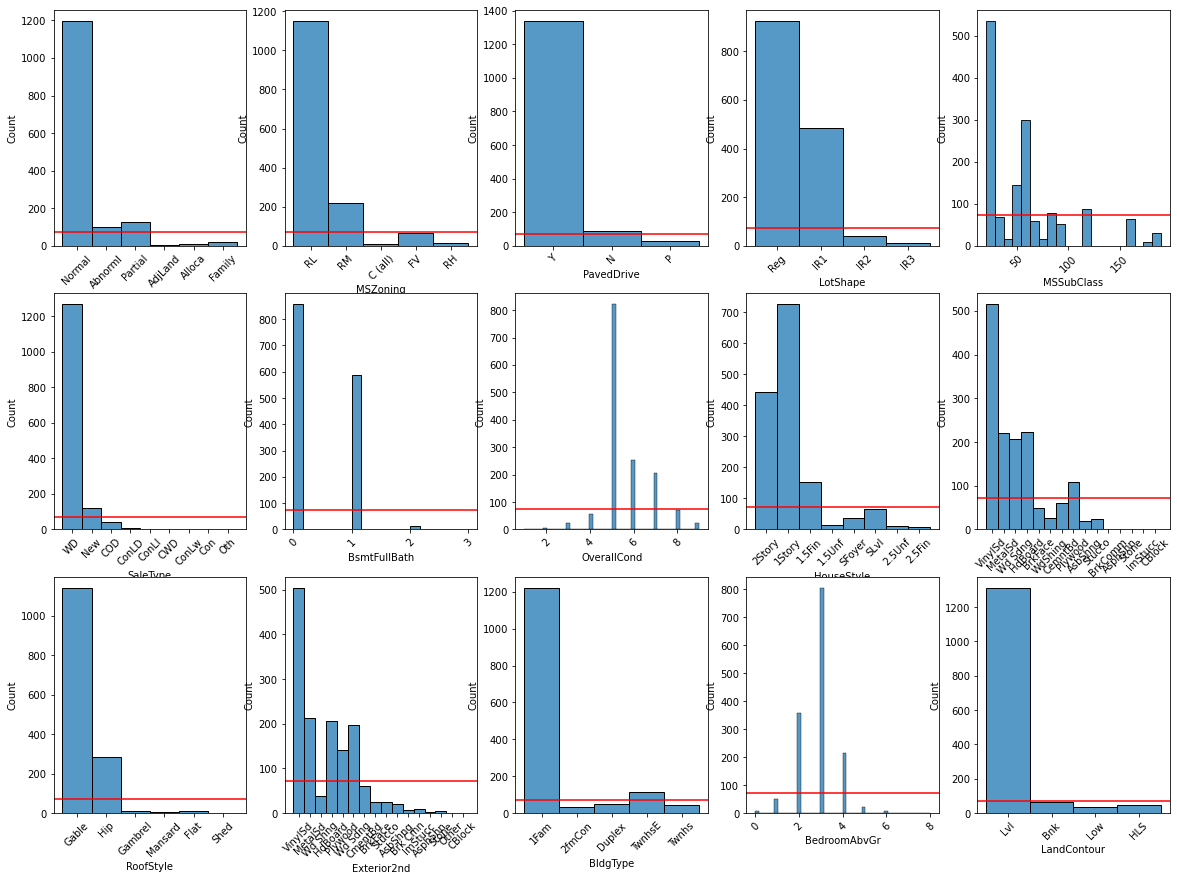

In [105]:
make_dist(without_nan_df,cols_with_low_F_score)

In [106]:
for col_info in cols_with_big_F_score+cols_with_low_F_score:
    # get value_counts in percentage
    col_name = col_info[0]
    print(without_nan_df[col_name].value_counts() / len(without_nan_df) * 100)
    print()

TA    62.054795
Gd    33.424658
Ex     3.561644
Fa     0.958904
Name: ExterQual, dtype: float64

TA    50.342466
Gd    40.136986
Ex     6.849315
Fa     2.671233
Name: KitchenQual, dtype: float64

2    56.438356
1    25.273973
3    12.397260
0     5.547945
4     0.342466
Name: GarageCars, dtype: float64

5     27.191781
6     25.616438
7     21.849315
8     11.506849
4      7.945205
9      2.945205
3      1.369863
10     1.232877
2      0.205479
1      0.136986
Name: OverallQual, dtype: float64

2    52.602740
1    44.520548
3     2.260274
0     0.616438
Name: FullBath, dtype: float64

0    47.260274
1    44.520548
2     7.876712
3     0.342466
Name: Fireplaces, dtype: float64

PConc     44.315068
CBlock    43.424658
BrkTil    10.000000
Slab       1.643836
Stone      0.410959
Wood       0.205479
Name: Foundation, dtype: float64

Y    93.493151
N     6.506849
Name: CentralAir, dtype: float64

Ex    50.753425
TA    29.315068
Gd    16.506849
Fa     3.356164
Po     0.068493
Name: HeatingQC,

CentralAir Has good F_score, but more then 90% of data contains same value. Does the house price really differ from this variable?
(also need to check SaleCondition(80%), MSZoning(78%),PavedDrive(91%), SaleType(86%), RoofStyle(78%), BldgType(83%), LandContour(89%))

In [107]:
cols_to_investigate = ['CentralAir', 'SaleCondition','MSZoning','PavedDrive','SaleType','RoofStyle','BldgType','LandContour']

In [108]:
invest_df = Full_train[cols_to_investigate+['price']]
invest_df

,CentralAir,SaleCondition,MSZoning,PavedDrive,SaleType,RoofStyle,BldgType,LandContour,price
Id,,,,,,,,,
1,Y,Normal,RL,Y,WD,Gable,1Fam,Lvl,208500
2,Y,Normal,RL,Y,WD,Gable,1Fam,Lvl,181500
3,Y,Normal,RL,Y,WD,Gable,1Fam,Lvl,223500
4,Y,Abnorml,RL,Y,WD,Gable,1Fam,Lvl,140000
5,Y,Normal,RL,Y,WD,Gable,1Fam,Lvl,250000
...,...,...,...,...,...,...,...,...,...
1456,Y,Normal,RL,Y,WD,Gable,1Fam,Lvl,175000
1457,Y,Normal,RL,Y,WD,Gable,1Fam,Lvl,210000
1458,Y,Normal,RL,Y,WD,Gable,1Fam,Lvl,266500


In [109]:
group = invest_df.groupby(['CentralAir'], as_index=False).mean()
group.head()

,CentralAir,price
0,N,105264.073684
1,Y,186186.709890


We can conclude, that price have big differnece depend on CentralAir!

In [110]:
for col in cols_to_investigate:
    group = invest_df.groupby([col], as_index=False).mean()
    print(group.head())
    print()

  CentralAir          price
0          N  105264.073684
1          Y  186186.709890

  SaleCondition          price
0       Abnorml  146526.623762
1       AdjLand  104125.000000
2        Alloca  167377.416667
3        Family  149600.000000
4        Normal  175202.219533

  MSZoning          price
0  C (all)   74528.000000
1       FV  214014.061538
2       RH  131558.375000
3       RL  191004.994787
4       RM  126316.830275

  PavedDrive          price
0          N  115039.122222
1          P  132330.000000
2          Y  186433.973881

  SaleType          price
0      COD  143973.255814
1      CWD  210600.000000
2      Con  269600.000000
3    ConLD  138780.888889
4    ConLI  200390.000000

  RoofStyle          price
0      Flat  194690.000000
1     Gable  171483.956179
2   Gambrel  148909.090909
3       Hip  218876.933566
4   Mansard  180568.428571

  BldgType          price
0     1Fam  185763.807377
1   2fmCon  128432.258065
2   Duplex  133541.076923
3    Twnhs  135911.627907
4   Twnh

We can conclude, that different groups have different price, so these are probably good features

also, we can get dic with column names and column values, that contains less then 5% of data

In [111]:
dic = get_dic_name_need_change()
dic

{'ExterQual': ['Fa', 'Ex'],
 'KitchenQual': ['Fa'],
 'GarageCars': [4],
 'OverallQual': [1, 2, 10, 3, 9],
 'FullBath': [0, 3],
 'Fireplaces': [3],
 'Foundation': ['Wood', 'Stone', 'Slab'],
 'HeatingQC': ['Po', 'Fa'],
 'HalfBath': [2],
 'TotRmsAbvGrd': [14, 2, 12, 3, 11, 10],
 'SaleCondition': ['AdjLand', 'Alloca', 'Family'],
 'MSZoning': ['C (all)', 'RH', 'FV'],
 'PavedDrive': ['P'],
 'LotShape': ['IR3', 'IR2'],
 'MSSubClass': [40, 180, 45, 75, 85, 190, 90, 80, 70, 160, 30],
 'SaleType': ['Con', 'Oth', 'CWD', 'ConLw', 'ConLI', 'ConLD', 'COD'],
 'BsmtFullBath': [3, 2],
 'OverallCond': [1, 2, 9, 3, 4, 8],
 'HouseStyle': ['2.5Fin', '2.5Unf', '1.5Unf', 'SFoyer', 'SLvl'],
 'Exterior1st': ['ImStucc',
  'CBlock',
  'AsphShn',
  'BrkComm',
  'Stone',
  'AsbShng',
  'Stucco',
  'WdShing',
  'BrkFace',
  'CemntBd'],
 'RoofStyle': ['Shed', 'Mansard', 'Gambrel', 'Flat'],
 'Exterior2nd': ['CBlock',
  'Other',
  'AsphShn',
  'Stone',
  'Brk Cmn',
  'ImStucc',
  'AsbShng',
  'BrkFace',
  'Stucco',
  

I need to be accurate with columns that listed above, they have values less than 5% of the entire column

In [112]:
features_cat_no_nan_very_good = [col[0] for col in cols_with_big_F_score]
print(features_cat_no_nan_very_good)

['ExterQual', 'KitchenQual', 'GarageCars', 'OverallQual', 'FullBath', 'Fireplaces', 'Foundation', 'CentralAir', 'HeatingQC', 'HalfBath', 'TotRmsAbvGrd']


In [113]:
cols_with_big_F_score

[['ExterQual', 443.33483141504627, 1.4395510967787893e-204],
 ['KitchenQual', 407.80635155838866, 3.0322127528400614e-192],
 ['GarageCars', 351.2074862087728, 1.1211287650612485e-211],
 ['OverallQual', 349.02683956930736, 0.0],
 ['FullBath', 246.06700392492812, 3.8021879324489406e-129],
 ['Fireplaces', 146.74117584536646, 4.4210010307257784e-83],
 ['Foundation', 100.25385058740888, 5.791895002232233e-91],
 ['CentralAir', 98.30534356615253, 1.8095061559267854e-22],
 ['HeatingQC', 88.39446198869796, 2.667062092104357e-67],
 ['HalfBath', 74.46970052103694, 1.6091449454034875e-31],
 ['TotRmsAbvGrd', 56.16423822142646, 1.1917103366526644e-103]]

In [114]:
features_cat_no_nan_maybe_good = [col[0] for col in cols_with_low_F_score]
print(features_cat_no_nan_maybe_good)

['SaleCondition', 'MSZoning', 'PavedDrive', 'LotShape', 'MSSubClass', 'SaleType', 'BsmtFullBath', 'OverallCond', 'HouseStyle', 'Exterior1st', 'RoofStyle', 'Exterior2nd', 'BldgType', 'BedroomAbvGr', 'LandContour']


In [115]:
cols_with_low_F_score

[['SaleCondition', 45.57842830969571, 7.988268404991176e-44],
 ['MSZoning', 43.84028167245718, 8.817633866272648e-35],
 ['PavedDrive', 42.02417941762533, 1.803568890651533e-18],
 ['LotShape', 40.13285166226295, 6.447523852011766e-25],
 ['MSSubClass', 33.73207641062383, 8.66216626609302e-79],
 ['SaleType', 28.863054116984088, 5.039766889462451e-42],
 ['BsmtFullBath', 27.448014806098907, 2.88243552729416e-17],
 ['OverallCond', 26.00317308892095, 7.962288819950615e-38],
 ['HouseStyle', 19.595000995981223, 3.376776535121222e-25],
 ['Exterior1st', 18.61174286624578, 2.5860887286376316e-43],
 ['RoofStyle', 17.80549722914421, 3.653523047099125e-17],
 ['Exterior2nd', 17.500839571369834, 4.8421856706985465e-43],
 ['BldgType', 13.011077169620851, 2.0567364604967015e-10],
 ['BedroomAbvGr', 12.92541345911101, 3.3043196450461637e-16],
 ['LandContour', 12.850188333283924, 2.7422167521379096e-08]]

### Handling cat features contains NaN

In [116]:
df_with_nan = Full_train[low_cardinality_cols_with_nans].copy(deep=True)
df_with_nan = df_with_nan.join(y_full)
df_with_nan

,Alley,MasVnrType,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature,price
Id,,,,,,,,,,,,,,,,,
1,NaN,BrkFace,Gd,TA,No,GLQ,Unf,SBrkr,NaN,Attchd,RFn,TA,TA,NaN,NaN,NaN,208500
2,NaN,None,Gd,TA,Gd,ALQ,Unf,SBrkr,TA,Attchd,RFn,TA,TA,NaN,NaN,NaN,181500
3,NaN,BrkFace,Gd,TA,Mn,GLQ,Unf,SBrkr,TA,Attchd,RFn,TA,TA,NaN,NaN,NaN,223500
4,NaN,None,TA,Gd,No,ALQ,Unf,SBrkr,Gd,Detchd,Unf,TA,TA,NaN,NaN,NaN,140000
5,NaN,BrkFace,Gd,TA,Av,GLQ,Unf,SBrkr,TA,Attchd,RFn,TA,TA,NaN,NaN,NaN,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,NaN,None,Gd,TA,No,Unf,Unf,SBrkr,TA,Attchd,RFn,TA,TA,NaN,NaN,NaN,175000
1457,NaN,Stone,Gd,TA,No,ALQ,Rec,SBrkr,TA,Attchd,Unf,TA,TA,NaN,MnPrv,NaN,210000
1458,NaN,None,TA,Gd,No,GLQ,Unf,SBrkr,Gd,Attchd,RFn,TA,TA,NaN,GdPrv,Shed,266500


In [117]:
df_with_nan.isna().sum()[df_with_nan.isna().sum() > 0]

Alley           1369
MasVnrType         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [118]:
Full_train['PoolArea'].value_counts()

0      1453
480       1
512       1
519       1
555       1
576       1
648       1
738       1
Name: PoolArea, dtype: int64

It seems that pool features are zero or Nan if No Pool, everything matches.

In [119]:
Full_train['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

It seems that Electrical have missed value, so it is better to drop this row

In [120]:
indicies_elec = Full_train['Electrical'].isna()[Full_train['Electrical'].isna()].index
indicies_elec

Int64Index([1380], dtype='int64', name='Id')

In [121]:
Full_train['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

It seems that MasVnrType have missed values, so it is better to drop these rows

In [122]:
indicies_masvnr = Full_train['MasVnrType'].isna()[Full_train['MasVnrType'].isna()].index
indicies_masvnr

Int64Index([235, 530, 651, 937, 974, 978, 1244, 1279], dtype='int64', name='Id')

features, that describe garage, have same count  of missed values. Probably, because they are all connected.
However, Basement features doesnot match.
Electricial seems to have missed value rather then it should be NaN.

In [123]:
# I added numeric features describing garage to garage_feat to ssee whole picture
garage_feat = ['GarageType','GarageFinish', 'GarageQual', 'GarageCond', 'GarageYrBlt', 'GarageCars', 'GarageArea']
nadf = Full_train[garage_feat].isna()

In [124]:
Full_train[garage_feat]

,GarageType,GarageFinish,GarageQual,GarageCond,GarageYrBlt,GarageCars,GarageArea
Id,,,,,,,
1,Attchd,RFn,TA,TA,2003.0,2,548
2,Attchd,RFn,TA,TA,1976.0,2,460
3,Attchd,RFn,TA,TA,2001.0,2,608
4,Detchd,Unf,TA,TA,1998.0,3,642
5,Attchd,RFn,TA,TA,2000.0,3,836
...,...,...,...,...,...,...,...
1456,Attchd,RFn,TA,TA,1999.0,2,460
1457,Attchd,Unf,TA,TA,1978.0,2,500
1458,Attchd,RFn,TA,TA,1941.0,1,252


In [125]:
(Full_train['GarageCars'] == 0).sum()

81

In [126]:
(Full_train['GarageArea'] == 0).sum()

81

In [127]:
Full_train['GarageYrBlt'].isna().sum()

81

In [128]:
Full_train[garage_feat][(nadf == True).any(axis=1)].head(5)

,GarageType,GarageFinish,GarageQual,GarageCond,GarageYrBlt,GarageCars,GarageArea
Id,,,,,,,
40,NaN,NaN,NaN,NaN,NaN,0,0
49,NaN,NaN,NaN,NaN,NaN,0,0
79,NaN,NaN,NaN,NaN,NaN,0,0
89,NaN,NaN,NaN,NaN,NaN,0,0
90,NaN,NaN,NaN,NaN,NaN,0,0


For economy of workspace, I see only 5 rows, but this picture is true for the rest of df. When we see NaN, it is either Nan, or 0 in other columns. There is no zero's in other places. So, We can be sure that NaN or 0 means 'No Garage'.

Also, I should try to make categorical features from numeric(at least for GarageYrBlt and GarageCars). Probably, it will be better

Here are bsm features, again - added some numeric features (probably it will be better for them to be categorical)

In [129]:
bsm_feat = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2', 
            'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
nadf = Full_train[bsm_feat].isna()
Full_train[bsm_feat][(nadf == True).any(axis=1)].head(5)

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
Id,,,,,,,,,,,
18,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0
40,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0
91,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0
103,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0
157,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0


It is the same picture in whole df, except in 2 rows

Rows with indices 333 and 949 are problematic, but in other cases everything seems like "No basement = NaN".

In [130]:
indices = [333,949]

In [131]:
Full_train[bsm_feat].loc[indices]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
Id,,,,,,,,,,,
333,Gd,TA,No,GLQ,NaN,1124,479,1603,3206,1,0
949,Gd,TA,NaN,Unf,Unf,0,0,936,936,0,0


It seems that thease houses have basements, but data about some columns is missing. Best choise, probably, just drop these rows,

In [132]:
indices_to_drop = list(indicies_masvnr) + indices + list(indicies_elec)
print(len(indices_to_drop))
print(indices_to_drop)

11
[235, 530, 651, 937, 974, 978, 1244, 1279, 333, 949, 1380]


I will account NaN as another category, replace NaN in df, drop problematic indices, and calculate ANOVA

In [133]:
df_with_nan.loc[indices_to_drop]

,Alley,MasVnrType,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature,price
Id,,,,,,,,,,,,,,,,,
235,NaN,NaN,Gd,TA,No,GLQ,Unf,SBrkr,TA,BuiltIn,Fin,TA,TA,NaN,NaN,NaN,216500
530,NaN,NaN,TA,TA,No,Rec,Unf,SBrkr,TA,Attchd,RFn,TA,TA,NaN,NaN,NaN,200624
651,NaN,NaN,Gd,TA,No,Unf,Unf,SBrkr,NaN,Attchd,RFn,TA,TA,NaN,NaN,NaN,205950
937,NaN,NaN,Gd,TA,No,GLQ,Unf,SBrkr,NaN,Attchd,RFn,TA,TA,NaN,NaN,NaN,184900
974,NaN,NaN,Gd,TA,No,Unf,Unf,SBrkr,NaN,Attchd,Fin,TA,TA,NaN,NaN,NaN,182000
978,Pave,NaN,Gd,TA,No,GLQ,Unf,SBrkr,NaN,Attchd,Fin,TA,TA,NaN,NaN,NaN,199900
1244,NaN,NaN,Ex,Gd,Gd,GLQ,Unf,SBrkr,Gd,Attchd,Fin,TA,TA,NaN,NaN,NaN,465000
1279,NaN,NaN,Gd,TA,No,GLQ,Unf,SBrkr,Gd,Attchd,RFn,TA,TA,NaN,NaN,NaN,237000
333,NaN,BrkFace,Gd,TA,No,GLQ,NaN,SBrkr,Gd,Attchd,RFn,TA,TA,NaN,NaN,NaN,284000


In [134]:
df_replaced_nan = df_with_nan.replace(np.nan, 'None').drop(indices_to_drop)
df_replaced_nan

,Alley,MasVnrType,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature,price
Id,,,,,,,,,,,,,,,,,
1,None,BrkFace,Gd,TA,No,GLQ,Unf,SBrkr,None,Attchd,RFn,TA,TA,None,None,None,208500
2,None,None,Gd,TA,Gd,ALQ,Unf,SBrkr,TA,Attchd,RFn,TA,TA,None,None,None,181500
3,None,BrkFace,Gd,TA,Mn,GLQ,Unf,SBrkr,TA,Attchd,RFn,TA,TA,None,None,None,223500
4,None,None,TA,Gd,No,ALQ,Unf,SBrkr,Gd,Detchd,Unf,TA,TA,None,None,None,140000
5,None,BrkFace,Gd,TA,Av,GLQ,Unf,SBrkr,TA,Attchd,RFn,TA,TA,None,None,None,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,None,None,Gd,TA,No,Unf,Unf,SBrkr,TA,Attchd,RFn,TA,TA,None,None,None,175000
1457,None,Stone,Gd,TA,No,ALQ,Rec,SBrkr,TA,Attchd,Unf,TA,TA,None,MnPrv,None,210000
1458,None,None,TA,Gd,No,GLQ,Unf,SBrkr,Gd,Attchd,RFn,TA,TA,None,GdPrv,Shed,266500


ANOVA

In [135]:
cols_that_need_further_investigation, cols_with_big_F_score, cols_with_low_F_score = score_ANOVA(df_replaced_nan)

In [136]:
print(cols_with_big_F_score)

[['BsmtQual', 311.0870193465474, 4.408334226027477e-193], ['GarageFinish', 212.46880314484883, 3.6868482388459835e-114], ['FireplaceQu', 120.40942231253038, 1.2841341523061e-106], ['MasVnrType', 111.25152531314731, 8.236375924746345e-65], ['GarageType', 80.39992099417306, 7.170486547379049e-87], ['BsmtFinType1', 63.650254195390744, 3.126373973671972e-70], ['BsmtExposure', 63.13324172516858, 3.1538852552642892e-49]]


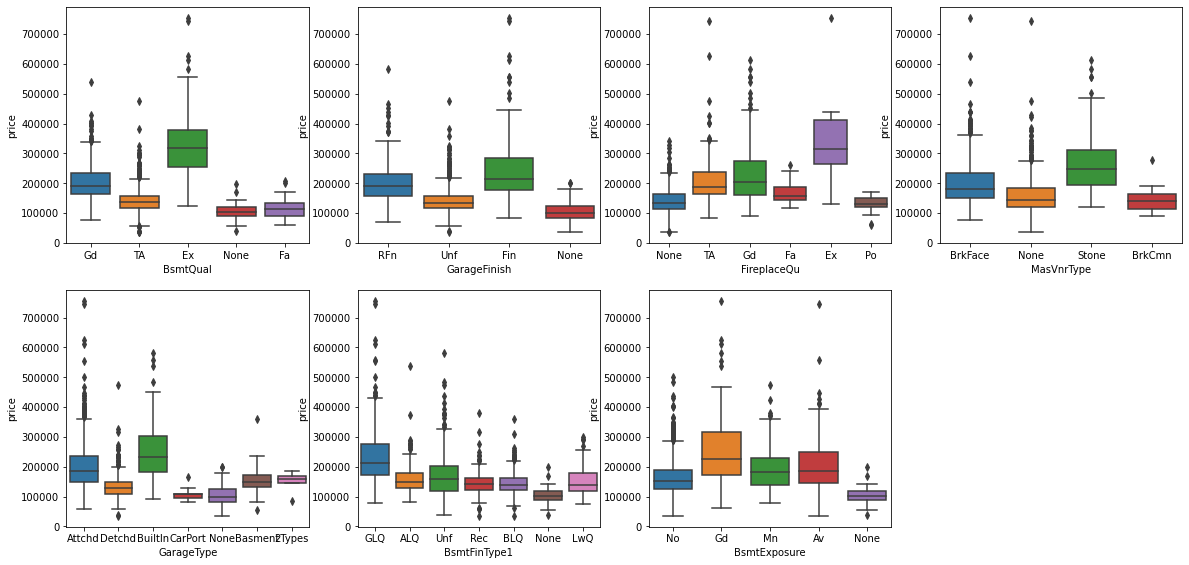

In [137]:
make_boxplots(cols_with_big_F_score, df_replaced_nan)

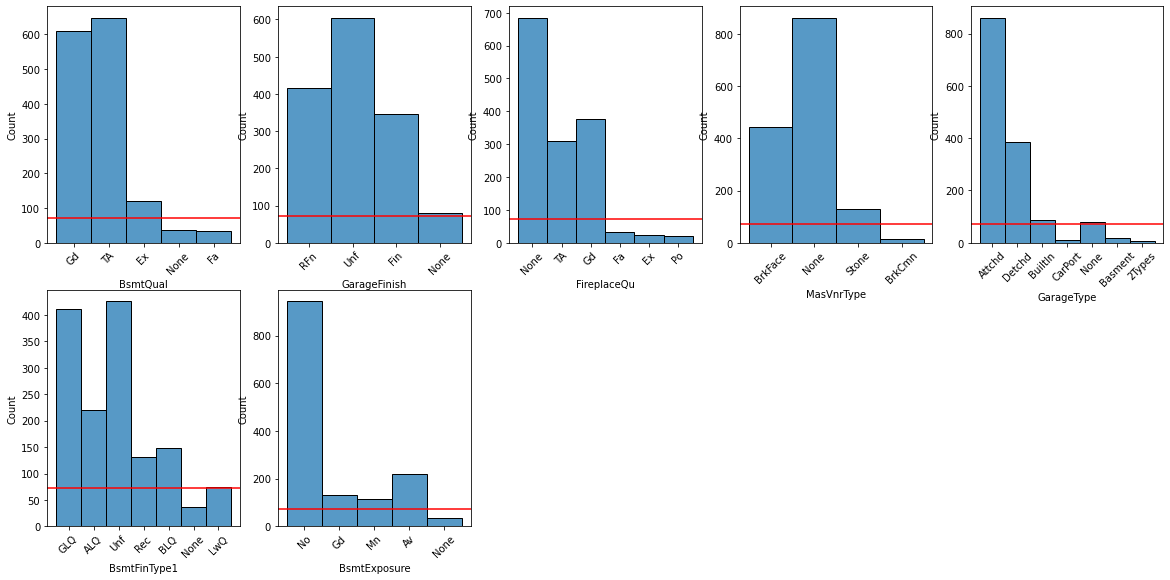

In [138]:
make_dist(df_replaced_nan, cols_with_big_F_score)

In [139]:
print(cols_with_low_F_score)

[['GarageQual', 25.626997200925967, 7.669355653656637e-25], ['GarageCond', 25.586766875916368, 8.39371920054518e-25], ['Electrical', 22.888668598959637, 2.3329415189596054e-18], ['BsmtCond', 18.987483594675634, 3.1324242362308705e-15], ['Alley', 15.066394051574353, 3.341889722957408e-07], ['Fence', 13.189765858834097, 1.480009872571321e-10], ['PoolQC', 10.576282461362517, 7.014115675459756e-07]]


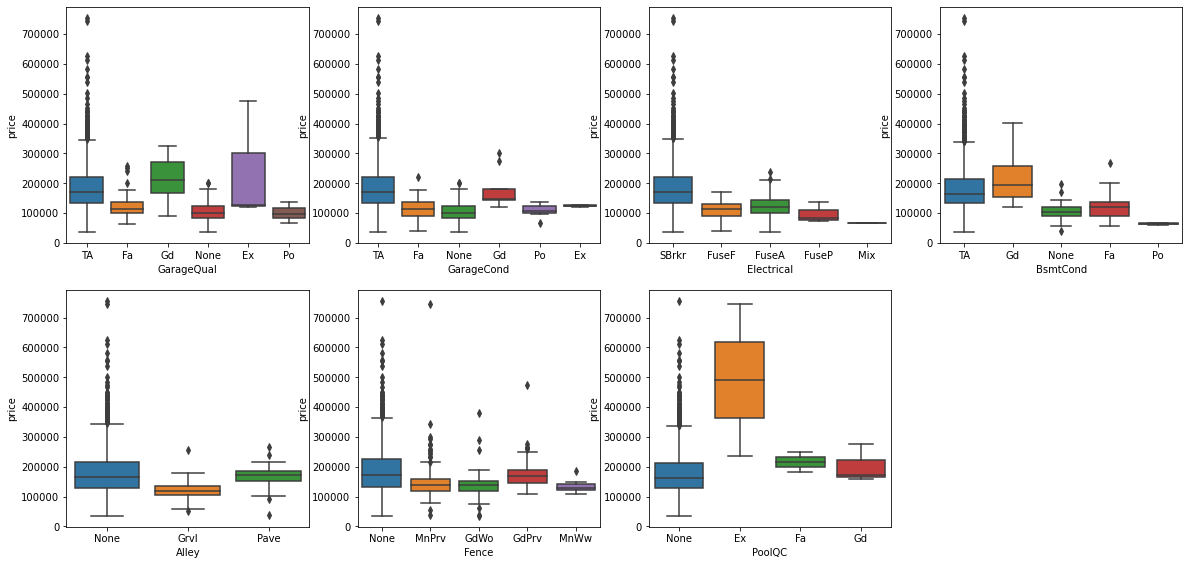

In [140]:
make_boxplots(cols_with_low_F_score,df_replaced_nan)

And distribution of it shows below

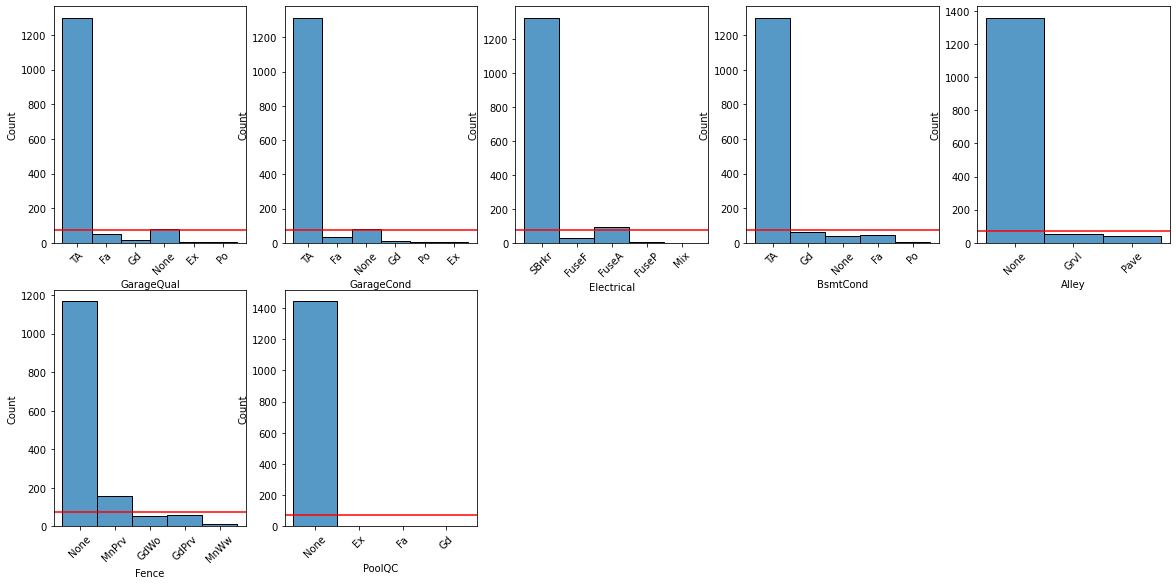

In [141]:
make_dist(df_replaced_nan, cols_with_low_F_score)

GarageQuality and BsmFinType1 are on line, using value_counts below shows that these variables are slight bigger than 5%

In [142]:
for col_info in cols_with_big_F_score+cols_with_low_F_score:
    # get value_counts in percentage
    col_name = col_info[0]
    print(df_replaced_nan[col_name].value_counts() / len(df_replaced_nan) * 100)
    print()

TA      44.720497
Gd      42.028986
Ex       8.281573
None     2.553485
Fa       2.415459
Name: BsmtQual, dtype: float64

Unf     41.752933
RFn     28.709455
Fin     23.947550
None     5.590062
Name: GarageFinish, dtype: float64

None    47.273982
Gd      26.017943
TA      21.394065
Fa       2.277433
Ex       1.656315
Po       1.380262
Name: FireplaceQu, dtype: float64

None       59.558316
BrkFace    30.572809
Stone       8.833678
BrkCmn      1.035197
Name: MasVnrType, dtype: float64

Attchd     59.420290
Detchd     26.708075
BuiltIn     5.935128
None        5.590062
Basment     1.311249
CarPort     0.621118
2Types      0.414079
Name: GarageType, dtype: float64

Unf     29.399586
GLQ     28.433402
ALQ     15.182885
BLQ     10.213941
Rec      9.109731
LwQ      5.106970
None     2.553485
Name: BsmtFinType1, dtype: float64

No      65.148378
Av      15.251898
Gd       9.178744
Mn       7.867495
None     2.553485
Name: BsmtExposure, dtype: float64

TA      89.717046
None     5.590062
Fa  

In [143]:
print(cols_that_need_further_investigation)

[['BsmtFinType2', 8.071348432572961, 1.3573809642470689e-08], ['MiscFeature', 2.552933678844972, 0.037457911493484666]]


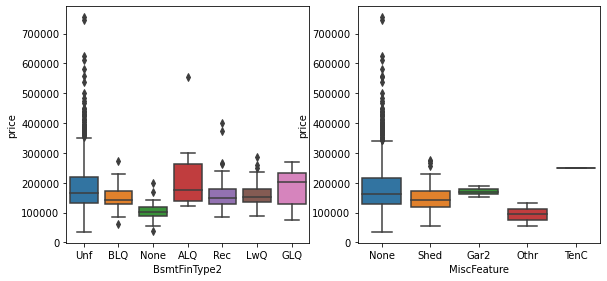

In [144]:
make_boxplots(cols_that_need_further_investigation,df_replaced_nan)

I have played around with different groups and come to conclusion, that None of combinations of MiscFeature will be good predicator. And as for BsmtFinType2, It is almsost straight line, so it is cannot be good feature either

In [145]:
df_group = df_replaced_nan[['MiscFeature', 'price']]
group = df_group.groupby('MiscFeature', as_index=False)

In [146]:
stats.f_oneway(group.get_group('Othr')['price'], group.get_group('Shed')['price'], group.get_group('Gar2')['price'])

F_onewayResult(statistic=1.3656109309677766, pvalue=0.26457831163508144)

In [147]:
features_cat_from_nan_very_good = [col[0] for col in cols_with_big_F_score]
print(features_cat_from_nan_very_good)

['BsmtQual', 'GarageFinish', 'FireplaceQu', 'MasVnrType', 'GarageType', 'BsmtFinType1', 'BsmtExposure']


In [148]:
features_cat_from_nan_maybe_good = [col[0] for col in cols_with_low_F_score]
print(features_cat_from_nan_maybe_good)

['GarageQual', 'GarageCond', 'Electrical', 'BsmtCond', 'Alley', 'Fence', 'PoolQC']


In [149]:
cols_with_low_F_score

[['GarageQual', 25.626997200925967, 7.669355653656637e-25],
 ['GarageCond', 25.586766875916368, 8.39371920054518e-25],
 ['Electrical', 22.888668598959637, 2.3329415189596054e-18],
 ['BsmtCond', 18.987483594675634, 3.1324242362308705e-15],
 ['Alley', 15.066394051574353, 3.341889722957408e-07],
 ['Fence', 13.189765858834097, 1.480009872571321e-10],
 ['PoolQC', 10.576282461362517, 7.014115675459756e-07]]

In [150]:
print(features_cat_from_nan_very_good)

['BsmtQual', 'GarageFinish', 'FireplaceQu', 'MasVnrType', 'GarageType', 'BsmtFinType1', 'BsmtExposure']


In [151]:
print(features_cat_no_nan_very_good)

['ExterQual', 'KitchenQual', 'GarageCars', 'OverallQual', 'FullBath', 'Fireplaces', 'Foundation', 'CentralAir', 'HeatingQC', 'HalfBath', 'TotRmsAbvGrd']


In [152]:
print(features_num_good_corr)

['GarageArea', 'TotalBsmtSF', '1stFlrSF', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'LotArea', 'BsmtUnfSF', 'ScreenPorch', 'BsmtFinSF2', 'EnclosedPorch', 'Total_Bath']


In [153]:
print(features_cat_from_nan_maybe_good)

['GarageQual', 'GarageCond', 'Electrical', 'BsmtCond', 'Alley', 'Fence', 'PoolQC']


In [154]:
print(features_cat_no_nan_maybe_good)

['SaleCondition', 'MSZoning', 'PavedDrive', 'LotShape', 'MSSubClass', 'SaleType', 'BsmtFullBath', 'OverallCond', 'HouseStyle', 'Exterior1st', 'RoofStyle', 'Exterior2nd', 'BldgType', 'BedroomAbvGr', 'LandContour']


In [155]:
X_full['Total_bath'] = X_full['FullBath'] + X_full['HalfBath']

# Cross features

In [156]:
from itertools import combinations, permutations

In [157]:
c = combinations([1,2,3],2)
for i in c:
    print(i)

(1, 2)
(1, 3)
(2, 3)


In [158]:
X_full.select_dtypes(exclude='object').columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'Total_bath'],
      dtype='object')

In [159]:
X_full['Total_bath'] = X_full['FullBath'] + X_full['HalfBath']

In [160]:
selected_features_df = X_full.select_dtypes(exclude='object')

In [161]:
total_columns = selected_features_df.columns
c = combinations(total_columns,2)
for comb in c:
    x1 = comb[0]
    x2 = comb[1]
    selected_features_df[[x1 + '_x_' + x2]] = selected_features_df[x1] * selected_features_df[x2]
selected_features_df = selected_features_df.join(y_full)

<ipython-input-161-24457da47cd5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_df[[x1 + '_x_' + x2]] = selected_features_df[x1] * selected_features_df[x2]
/home/leo/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [162]:
X_full.isna().sum()[X_full.isna().sum() > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [163]:
X_full.select_dtypes(exclude='object')

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,Total_bath
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,3
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,2
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,3
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,1
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,0,40,0,0,0,0,0,8,2007,3
1457,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,349,0,0,0,0,0,0,2,2010,2
1458,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,0,60,0,0,0,0,2500,5,2010,2


In [164]:
cross_features_df = selected_features_df.iloc[:, X_full.select_dtypes(exclude='object').shape[1]:]
cross_features_df

,MSSubClass_x_LotFrontage,MSSubClass_x_LotArea,MSSubClass_x_OverallQual,MSSubClass_x_OverallCond,MSSubClass_x_YearBuilt,MSSubClass_x_YearRemodAdd,MSSubClass_x_MasVnrArea,MSSubClass_x_BsmtFinSF1,MSSubClass_x_BsmtFinSF2,MSSubClass_x_BsmtUnfSF,...,PoolArea_x_MoSold,PoolArea_x_YrSold,PoolArea_x_Total_bath,MiscVal_x_MoSold,MiscVal_x_YrSold,MiscVal_x_Total_bath,MoSold_x_YrSold,MoSold_x_Total_bath,YrSold_x_Total_bath,price
Id,,,,,,,,,,,,,,,,,,,,,
1,3900.0,507000,420,300,120180,120180,11760.0,42360,0,9000,...,0,0,0,0,0,0,4016,6,6024,208500
2,1600.0,192000,120,160,39520,39520,0.0,19560,0,5680,...,0,0,0,0,0,0,10035,10,4014,181500
3,4080.0,675000,420,300,120060,120120,9720.0,29160,0,26040,...,0,0,0,0,0,0,18072,27,6024,223500
4,4200.0,668500,490,350,134050,137900,0.0,15120,0,37800,...,0,0,0,0,0,0,4012,2,2006,140000
5,5040.0,855600,480,300,120000,120000,21000.0,39300,0,29400,...,0,0,0,0,0,0,24096,36,6024,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,3720.0,475020,360,300,119940,120000,0.0,0,0,57180,...,0,0,0,0,0,0,16056,24,6021,175000
1457,1700.0,263500,120,120,39560,39760,2380.0,15800,3260,11780,...,0,0,0,0,0,0,4020,4,4020,210000
1458,4620.0,632940,490,630,135870,140420,0.0,19250,0,61390,...,0,0,0,12500,5025000,5000,10050,10,4020,266500


In [165]:
cross_features_df = cross_features_df.dropna()

In [166]:
#cols_that_need_further_investigation, cols_with_big_F_score, cols_with_low_F_score  = score_ANOVA(cross_features_df)

In [167]:
#cols_with_big_F_score

In [168]:
#make_boxplots(cols_with_big_F_score[:15],data=cross_features_df,subplot_size=[6,6,1])

In [169]:
#cols_with_low_F_score[:15]

In [170]:
#s = cols_with_low_F_score

In [171]:
#cols_with_low_F_score[:15]

In [172]:
#make_boxplots(s[:10],data=cross_features_df,subplot_size=[6,6,1])

In [173]:
cross_corr = cross_features_df.corr()['price'].sort_values(ascending=False).dropna()

In [174]:
cross_corr[cross_corr > 0.75]

price                         1.000000
OverallQual_x_GrLivArea       0.826132
OverallQual_x_GarageCars      0.818158
OverallQual_x_TotRmsAbvGrd    0.804248
GrLivArea_x_GarageCars        0.803609
OverallQual_x_YearBuilt       0.802169
OverallQual_x_GarageYrBlt     0.801571
OverallQual_x_YearRemodAdd    0.801484
OverallQual_x_YrSold          0.797866
OverallQual_x_GarageArea      0.789648
OverallQual_x_1stFlrSF        0.776155
1stFlrSF_x_Total_bath         0.767740
TotalBsmtSF_x_Total_bath      0.765881
OverallQual_x_FullBath        0.760898
1stFlrSF_x_GarageCars         0.753151
TotalBsmtSF_x_GarageCars      0.753117
OverallQual_x_Total_bath      0.752851
Name: price, dtype: float64

In [175]:
cross_cols = cross_corr[cross_corr > 0.5].iloc[1:].index

In [176]:
new_Full_df = selected_features_df.join(X_full.select_dtypes(include='object'))
new_Full_df

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1457,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1458,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal


In [177]:
print(features_cat_from_nan_very_good)

['BsmtQual', 'GarageFinish', 'FireplaceQu', 'MasVnrType', 'GarageType', 'BsmtFinType1', 'BsmtExposure']


In [178]:
print(features_cat_no_nan_very_good)

['ExterQual', 'KitchenQual', 'GarageCars', 'OverallQual', 'FullBath', 'Fireplaces', 'Foundation', 'CentralAir', 'HeatingQC', 'HalfBath', 'TotRmsAbvGrd']


In [179]:
print(features_num_good_corr)

['GarageArea', 'TotalBsmtSF', '1stFlrSF', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'LotArea', 'BsmtUnfSF', 'ScreenPorch', 'BsmtFinSF2', 'EnclosedPorch', 'Total_Bath']


In [180]:
print(features_cat_from_nan_maybe_good)

['GarageQual', 'GarageCond', 'Electrical', 'BsmtCond', 'Alley', 'Fence', 'PoolQC']


In [181]:
print(features_cat_no_nan_maybe_good)

['SaleCondition', 'MSZoning', 'PavedDrive', 'LotShape', 'MSSubClass', 'SaleType', 'BsmtFullBath', 'OverallCond', 'HouseStyle', 'Exterior1st', 'RoofStyle', 'Exterior2nd', 'BldgType', 'BedroomAbvGr', 'LandContour']


In [182]:
new_Full_df['Total_Bath'] = new_Full_df['FullBath'] + new_Full_df['HalfBath']

In [183]:
new_train_df = new_Full_df[['price'] + features_cat_from_nan_very_good + features_cat_no_nan_very_good + 
           features_num_good_corr + features_cat_from_nan_maybe_good + features_cat_no_nan_maybe_good +
           list(cross_cols)
           ]

In [184]:
new_train_df

,price,BsmtQual,GarageFinish,FireplaceQu,MasVnrType,GarageType,BsmtFinType1,BsmtExposure,ExterQual,KitchenQual,...,BsmtFinSF1_x_FullBath,LotArea_x_GarageCars,1stFlrSF_x_BedroomAbvGr,LotFrontage_x_TotRmsAbvGrd,GarageYrBlt_x_YrSold,OverallQual_x_BsmtFinSF1,MasVnrArea_x_WoodDeckSF,OverallCond_x_Total_bath,OverallCond_x_1stFlrSF,LotArea_x_Total_bath
Id,,,,,,,,,,,,,,,,,,,,,
1,208500,Gd,RFn,NaN,BrkFace,Attchd,GLQ,No,Gd,Gd,...,1412,16900,2568,520.0,4022024.0,4942,0.0,15,4280,25350
2,181500,Gd,RFn,TA,None,Attchd,ALQ,Gd,TA,TA,...,1956,19200,3786,480.0,3965832.0,5868,0.0,16,10096,19200
3,223500,Gd,RFn,TA,BrkFace,Attchd,GLQ,Mn,Gd,Gd,...,972,22500,2760,408.0,4018008.0,3402,0.0,15,4600,33750
4,140000,TA,Unf,Gd,None,Detchd,ALQ,No,TA,Gd,...,216,28650,2883,420.0,4007988.0,1512,0.0,5,4805,9550
5,250000,Gd,RFn,TA,BrkFace,Attchd,GLQ,Av,Gd,Gd,...,1310,42780,4580,756.0,4016000.0,5240,67200.0,15,5725,42780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,175000,Gd,RFn,TA,None,Attchd,Unf,No,TA,TA,...,0,15834,2859,434.0,4011993.0,0,0.0,15,4765,23751
1457,210000,Gd,Unf,TA,Stone,Attchd,ALQ,No,TA,TA,...,1580,26350,6219,595.0,3975780.0,4740,41531.0,12,12438,26350
1458,266500,TA,RFn,Gd,None,Attchd,GLQ,No,Ex,Gd,...,550,9042,4752,594.0,3901410.0,1925,0.0,18,10692,18084
